## FinalProject - Topic Modeling

**Submitted by : Tanvi Arora**   
**Section     : DS 7337 Natural Language Processing - 401**

<a id="top"></a>
### Contents

* <a href="#functionswebscrap">Function Definitions for Webscraping</a>
* <a href="#datacollect">Data Collection</a>
* <a href="#functionspreptext">Function Definitions - Pre-process text</a>
* <a href="#preptext">Pre-process user reviews</a>
* <a href="#topicmodelgenism">LDA Topic Modelling with Gensim with viz</a>
* <a href="#topicmodelsklearn">LDA Topic Modelling with sklearn with viz</a>

In [116]:
import platform
print(platform.platform())

import os
print ("environment",os.environ['CONDA_DEFAULT_ENV'])

import sys
print("Python",sys.version)

## ignore/suppress warnings
import warnings
warnings.simplefilter('ignore', DeprecationWarning)
warnings.simplefilter('ignore', FutureWarning)


import nltk
from nltk import word_tokenize
from nltk.corpus import stopwords
print("nltk",nltk.__version__)

#from nltk.tag.util import tuple2str

import numpy
import numpy as np
print("numpy", numpy.__version__)

from bs4 import BeautifulSoup
import requests
#from __future__ import division, unicode_literals 
from urllib import request
from tabulate import tabulate
import pandas as pd
print("pandas", pd.__version__)

# Plotting tools
import pyLDAvis
import pyLDAvis.gensim  # don't skip this
import matplotlib
import matplotlib.pyplot as plt
import pyLDAvis.sklearn
%matplotlib inline
import matplotlib.colors as mcolors
print("matplotlib", matplotlib.__version__)
print("pyLDAvis", pyLDAvis.__version__)
from wordcloud import WordCloud, STOPWORDS


import bokeh
import bokeh.plotting as bp
from bokeh.plotting import save
from bokeh.models import HoverTool
print("bokeh", bokeh.__version__)

pd.set_option('display.max_rows',10)
import re
from random import randint
import string
import collections
import unicodedata
from pprint import pprint

## spaCy library
import spacy
sp_nlp=spacy.load('en')
print("spacy", spacy.__version__)

# Gensim
import gensim
import gensim.corpora as corpora
from gensim.utils import simple_preprocess
from gensim.models import CoherenceModel
from gensim.models.phrases import Phraser ,Phrases
print("gensim", gensim.__version__)

# Sklearn
import sklearn
from sklearn.decomposition import LatentDirichletAllocation, TruncatedSVD
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import GridSearchCV
print("sklearn", sklearn.__version__)


import datetime
import time

from selenium import webdriver
from selenium.common.exceptions import NoSuchElementException
from selenium.webdriver.common.by import By
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC

options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument('--incognito')
options.add_argument('--headless')
driver = webdriver.Chrome("/usr/local/bin/chromedriver", chrome_options=options)

Darwin-18.6.0-x86_64-i386-64bit
environment base
Python 3.7.3 (default, Mar 27 2019, 16:54:48) 
[Clang 4.0.1 (tags/RELEASE_401/final)]
nltk 3.4
numpy 1.16.1
pandas 0.24.2
matplotlib 3.0.3
pyLDAvis 2.1.2
bokeh 1.0.4
spacy 2.1.4
gensim 3.4.0
sklearn 0.20.3


### References :

https://www.dataquest.io/blog/web-scraping-beautifulsoup/  
https://medium.com/@madanflies/top-50-shows-recommendation-scrap-from-imdb-using-beautiful-soup-in-python-610035ac1eb7  
https://medium.com/ymedialabs-innovation/web-scraping-using-beautiful-soup-and-selenium-for-dynamic-page-2f8ad15efe25   
http://stackoverflow.com/questions/19790188/expanding-english-language-contractions-in-python  
https://www.machinelearningplus.com/nlp/topic-modeling-gensim-python/  
https://towardsdatascience.com/topic-modelling-in-python-with-nltk-and-gensim-4ef03213cd21  
https://www.machinelearningplus.com/nlp/topic-modeling-visualization-how-to-present-results-lda-models/



<a id="functionswebscrap"></a>
<a href="#top">Back to Top</a>

### Function Definitions - WebScraping

In [3]:
## call main URL


## returns webpage content if web page accessible else None
def getSoup(url):
    grab_page = requests.get(url,timeout=5)
    if grab_page.status_code != 200:
        print("Error:page not found")
        return None
    else:
        #print("page found")
        return BeautifulSoup(grab_page.content, 'html5lib')

## basic beautiful soup read function 
def read_html(url):
    html = request.urlopen(url).read().decode('utf8')
    raw = BeautifulSoup(html, 'html.parser').get_text()
    tokens = word_tokenize(raw)
    text = nltk.Text(tokens)
    return text

## fetch main page data
def get_movie_home_container(searchurl):
    moviehome_soup=getSoup(searchurl)
    return moviehome_soup.find_all('div', class_ = "lister-item-content"),moviehome_soup.find('a', class_='lister-page-next next-page').get('href')

## fetch movie list from the main page data
## currently this function gets data from default or first page from search url
## this function returns a dataframe that contains list of movie names, individual movie links
## imdb ratings ( average of user ratings), metascores and # of votes that can be use for 
## further data analysis
def get_movielist_home(homecontainer):
    names=[]
    movielinks=[]
    imdb_ratings=[]
    metascores=[]
    votes=[]
    
    for container in homecontainer:
        #print(container.h3.a.text)
        names.append(container.h3.a.text)
    # Look for movies with a Metascore
        movie_url=baseurl+container.h3.a.attrs["href"]
        movielinks.append(movie_url)
        
        if container.find('div', class_='inline-block ratings-metascore') is not None:
            metascores.append(float(container.find('span',class_='metascore').text))
        else:
            metascores.append('')
            
        
        if container.strong is not None:    
            imdb_ratings.append(float(container.strong.text))
        else:
            imdb_ratings.append('')
            
        if container.find('span',attrs = {'name':'nv'}) is not None:
            votes.append(container.find('span',attrs = {'name':'nv'})['data-value'])
        else:
            votes.append('')
        
        
        m_df=pd.DataFrame({'moviename':names,
                      'movielinks':movielinks,
                      'imdb_ratings':imdb_ratings,
                      'metascores':metascores,
                      'votes':votes})
    return m_df

def create_movielist(searchlink,filename,restart_c=0):

    moviehome_container,nextsearchpg=get_movie_home_container(searchlink)
    movie_df_next=get_movielist_home(moviehome_container)
    if restart_c==0:
        movie_df_next.to_csv(filename, mode='a', index=False, header=True)
    c=1
    try:
        while baseurl+nextsearchpg is not None:
            moviehome_container,nextsearchpg=get_movie_home_container(baseurl+nextsearchpg)

            if restart_c<c:
                movie_df_next=get_movielist_home(moviehome_container)
                movie_df_next.to_csv(filename, mode='a', index=False, header=False)
            
            c=c+1
    except Exception as e:
        print("Exception raised : ", e)
        print("last processed c is :",c)

## This function returns the main user review page from the individual movie link
def get_movie_user_review_link(movie_url):
    imovie_containers=[]
    imovie_soup=getSoup(movie_url)
    imovie_userreview_container = imovie_soup.find_all('div', class_ = "user-comments")
    #print(movie_url)
    try:
        imovie_user_review_link=[baseurl+alink.attrs["href"] for alink in imovie_userreview_container[0].find_all('a') if re.findall(re.compile("user reviews$",re.IGNORECASE),alink.text)]
    except IndexError as i:
        imovie_user_review_link=[]
    except Exception as e:
        print("movie url :", movie_url)
        print("Unexpected Error :",e)
    return imovie_user_review_link

## This function gets the cast and character list that can be further used to 
## build a custom lexicon for Proper Nouns
def get_movie_cast_charc_list(movie_url):
    imovie_soup=getSoup(movie_url)
    imovie_cast_container=imovie_soup.find_all('table', class_ = "cast_list")
    cast_list=[re.sub('\s+',' ',(cast.find('a').text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_=None)]
    character_list=[re.sub('\s+',' ',(cast.text).strip(' \n\t')) for cast in imovie_cast_container[0].find_all('td', class_="character")]
    return (cast_list,character_list)


    
## This function returns a dataframe of individual user review links(permalink) and some
## additional information for each user review like review_date, user_rating , 
## user rating pointscale and user review title
## It also accepts number of reviews required per movie as input
def get_movie_user_reviews(movie_df):
    m_ind=0
    movie_name=[]
    review_date=[]
    user_rating=[]
    user_pointscale=[]
    permalink=[]
    title=[]

    for m in movie_df["user_review_link"]:
        #print("review page :", m)
        m_ind=m_ind+1
        #print("movie# :", m_ind-1)
        print("link :",m[0])
        user_review_soup=getSoup(m[0])
        imovie_user_review_list_container=user_review_soup.find_all('div', class_=re.compile("lister-item mode-detail imdb-user-review*"))
        
        for ur in imovie_user_review_list_container:
            #print(ur.find('a', class_='title').text)
            rating=[int(rating.text) for rating in ur.find_all('span', class_=None) if (rating.text.isnumeric() and rating.text is not None)]
            #print("rating: ",rating)
            if len(rating)!=0:
                movie_name.append(movie_df['moviename'][m_ind])
                user_rating.append(rating[0])
                review_date.append(ur.find('span',class_="review-date").text)
                user_pointscale.append(ur.find_all('span', class_='point-scale')[0].text)
                #user_review.append(ur.find('div', class_=re.compile(r"show-more")).text)
                permalink.append([ baseurl+link.attrs["href"] for link in ur.find_all('a') if link.text=="Permalink"][0])
                title.append(ur.find('a', class_='title').text)
                #print(ur.find('a', class_='title').text)
                #print(ur.find('div', class_=re.compile(r"show-more")).text)
                
    
    user_review_df=pd.DataFrame({"movie_name":movie_name,
                                "user_rating":user_rating,
                                "rating_point_scale":user_pointscale,
                                "review_date":review_date,
                                "permalink":permalink,
                                "title":title})
    return user_review_df

## this function returns actual user review text and title from the individual user review link(permalink)
def get_iuser_review(user_review_url):
    imovie_name=[]
    ireview_title=[]
    iuser_review=[]
    ireview_soup=getSoup(user_review_url)
    ireview_container=ireview_soup.find_all('div', class_="lister-item-content")
    for review in ireview_container:
        iuser_review=review.find('div', class_=re.compile(r"show-more")).text
    
    return iuser_review


## This function returns a dataframe of individual user review links(permalink) and some
## additional information for each user review like review_date, user_rating , 
## user rating pointscale and user review title
## It also accepts number of reviews required per movie as input
def get_user_reviews_data(moviename,movie_user_review_url):
    
    movie_name=[]
    review_date=[]
    user_rating=[]
    user_pointscale=[]
    permalink=[]
    user_review=[]
    title=[]
    c=1

    #movie_user_review_source=get_moreuser_reviews(movie_user_review_url)
    user_review_soup=getSoup(movie_user_review_url)
    imovie_user_review_list_container=user_review_soup.find_all('div', class_=re.compile("lister-item mode-detail imdb-user-review*"))

    for ur in imovie_user_review_list_container:
        #print(ur.find('a', class_='title').text)
        movie_name.append(moviename)
        try:
            rating=[int(rating.text) for rating in ur.find_all('span', class_=None) if (rating.text.isnumeric() and rating.text is not None)]
            #print("rating: ",rating)
            if len(rating)!=0:
                user_rating.append(rating[0])
                try:
                    point_sc=ur.find_all('span', class_='point-scale')[0].text
                    if point_sc:
                        user_pointscale.append(point_sc)
                    else:
                        user_pointscale.append('')
                except Exception as eps:
                    user_pointscale.append('')
                    print("Task failed at counter :",c)
                    print("Exception :",eps)
                    pass
            else:
                user_rating.append('')
                user_pointscale.append('')
        except Exception as er:
            user_rating.append('')
            user_pointscale.append('')
            print("Task failed at counter :",c)
            print("Exception :",er)

            

        try:
            rev_dt=ur.find('span',class_="review-date").text
            if len(rev_dt) != 0:
                review_date.append(rev_dt)
            else:
                review_date.append('')
        except Exception as erd:
            review_date.append('')
            print("Task failed at counter :",c)
            print("Exception :",erd)

        

        try:
            perma_link=[ baseurl+link.attrs["href"] for link in ur.find_all('a') if link.text=="Permalink"][0]
            if len(perma_link) != 0:
                #user_review.append(ur.find('div', class_=re.compile(r"show-more")).text)
                permalink.append(perma_link)
                user_rev=get_iuser_review(perma_link)
                if len(user_rev) != 0:
                    user_review.append(user_rev)
                else:
                    user_review.append('')
            else:
                permalink.append('')
                user_review.append('')
        except Exception as epl:
            permalink.append('')
            user_review.append('')
            print("Task failed at counter :",c)
            print("Exception :",epl)

        try:
            tit=ur.find('a', class_='title').text
            if len(title) != 0:
                title.append(tit)
            else:
                title.append('')
        except Exception as et:
            title.append('')
            print("Task failed at counter :",c)
            print("Exception :",et)
        
        c=c+1
        

    print("reviews fetched for movie :",moviename) 
        
    try:
        user_review_df=pd.DataFrame({"movie_name":movie_name,
                                "user_rating":user_rating,
                                "rating_point_scale":user_pointscale,
                                "review_date":review_date,
                                "permalink":permalink,
                                "user_review":user_review,
                                "title":title})
    except Exception as edf:
        print("length of lists :")
        print(len(movie_name),len(user_rating),len(user_pointscale),len(review_date),len(permalink),len(user_review),len(title))
    
    return user_review_df


## based on user rating this function returns if review is positive(>=5) or negative(<5)
def get_user_rating_label(rating):
    if rating is None:
        return ''
    if pd.to_numeric(rating) >=5:
        return "positive"
    else:
        return "negative"

def get_moreuser_reviews(review_url):
    options = webdriver.ChromeOptions()
    options.add_argument('--ignore-certificate-errors')
    options.add_argument('--incognito')
    options.add_argument('--headless')
    driver = webdriver.Chrome("/usr/local/bin/chromedriver", chrome_options=options)
    driver.get(review_url)

    exception_patt=re.compile("element not interactable")
    while True:
        try:
            try:
                loaded=driver.find_element_by_class_name("ipl-load-more ipl-load-more--loaded-all")
                print("loaded :",loaded)
            except Exception as e:
                loaded=None

            if loaded is None:
                loadMoreButton = driver.find_element_by_id("load-more-trigger")
                time.sleep(2)
                loadMoreButton.click()
                time.sleep(5)
            else:
                print("Fetched entire page")
                break
        except Exception as e:
            break
    print("Complete")
    time.sleep(10)

    page_source = driver.page_source
    driver.quit()


## this function returns NP using spaCy library
def get_np_chunks(sentence):
    doc=sp_nlp(sentence)
    return [np.text for np in doc.noun_chunks]        

<a id="datacollect"></a>
<a href="#top">Back to Top</a>
### Movie Data Collection

**website** www.imdb.com  
**Genre** Biography

### Movie Selection

In [4]:
## Call Main
#del [[movie_df]]
## call function to create movielist file, else load file
baseurl="https://www.imdb.com"
biographylink="https://www.imdb.com/search/title/?release_date=2010-01-01,2019-12-31&genres=biography&page=1"
moviefilename='imdb_movie_biography.csv'
restart_c=0

if os.path.exists(moviefilename) and restart_c==0:
    print("File already exists")
    movie_df=pd.read_csv(moviefilename,header=0)
else:
    print("File needs to be created")
    start = datetime.datetime.now()
    print("started at :",start)
    create_movielist(biographylink,moviefilename,restart_c)
    end = datetime.datetime.now()
    print("Ended at :",end)
    print(" Time taken to extract movie links : ", end - start)
    movie_df=pd.read_csv(moviefilename,header=0)



print(len(movie_df))
movie_df.head()



    

File already exists
39300


,moviename,movielinks,imdb_ratings,metascores,votes
0,A Beautiful Day in the Neighborhood,https://www.imdb.com/title/tt3224458/,NaN,NaN,NaN
1,Skin,https://www.imdb.com/title/tt6043142/,7.1,58.0,4415
2,First Man,https://www.imdb.com/title/tt1213641/,7.3,84.0,128385
3,Harriet,https://www.imdb.com/title/tt4648786/,NaN,NaN,NaN
4,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,365275


**For our analysis, we have chosen 200 movies from the list of movies collected.**

In [5]:
#del [[movie_sel_df]]
movie_df["user_review_link"]=movie_df.apply(lambda _: '', axis=1)
movie_sel_df=movie_df.head(200)
print(len(movie_sel_df))
movie_sel_df.head()


200


,moviename,movielinks,imdb_ratings,metascores,votes,user_review_link
0,A Beautiful Day in the Neighborhood,https://www.imdb.com/title/tt3224458/,NaN,NaN,NaN,
1,Skin,https://www.imdb.com/title/tt6043142/,7.1,58.0,4415,
2,First Man,https://www.imdb.com/title/tt1213641/,7.3,84.0,128385,
3,Harriet,https://www.imdb.com/title/tt4648786/,NaN,NaN,NaN,
4,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,365275,


In [7]:
## Get user review page for each movie
movierevpgfilename='imdb_movie_biography_revpg.csv'
if os.path.exists(movierevpgfilename):
    print("File already exists")
    movie_sel_df=pd.read_csv(movierevpgfilename,header=0)
    movie_sel_df.head()
else:
    movie_sel_df["user_review_link"]=movie_sel_df.apply(lambda row : get_movie_user_review_link(row["movielinks"]), axis=1)
    movie_sel_df.to_csv(movierevpgfilename,index=False, header=True)
    movie_sel_df.head()

/Users/tanviarora/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


For some of the movies, user_review link is not fetched, this can cause failures so a new dataframe is created for the list of movies that have a user review link page

In [8]:
len(movie_sel_df['user_review_link'][0])

0

In [9]:
#del [[movie_user_sel_df]]
movie_user_sel_df=movie_sel_df[movie_sel_df.astype(str)['user_review_link']!='[]']

In [10]:
movie_user_sel_df.index = pd.RangeIndex(len(movie_user_sel_df.index))
movie_user_sel_df


,moviename,movielinks,imdb_ratings,metascores,votes,user_review_link
0,Skin,https://www.imdb.com/title/tt6043142/,7.1,58.0,4415,[https://www.imdb.com/title/tt6043142/reviews]
1,First Man,https://www.imdb.com/title/tt1213641/,7.3,84.0,128385,[https://www.imdb.com/title/tt1213641/reviews]
2,Bohemian Rhapsody,https://www.imdb.com/title/tt1727824/,8.0,49.0,365275,[https://www.imdb.com/title/tt1727824/reviews]
3,When They See Us,https://www.imdb.com/title/tt7137906/,9.0,NaN,37709,[https://www.imdb.com/title/tt7137906/reviews]
4,Super 30,https://www.imdb.com/title/tt7485048/,8.5,NaN,7166,[https://www.imdb.com/title/tt7485048/reviews]
...,...,...,...,...,...,...
181,All Is True,https://www.imdb.com/title/tt9206798/,6.1,59.0,1078,[https://www.imdb.com/title/tt9206798/reviews]
182,Borg vs. McEnroe,https://www.imdb.com/title/tt5727282/,7.0,63.0,21613,[https://www.imdb.com/title/tt5727282/reviews]
183,Kill the Messenger,https://www.imdb.com/title/tt1216491/,7.0,60.0,41545,[https://www.imdb.com/title/tt1216491/reviews]
184,Yip Man 3,https://www.imdb.com/title/tt2888046/,7.1,57.0,39258,[https://www.imdb.com/title/tt2888046/reviews]


### User Reviews Selection for each movie

Each movie user review page is scraped to fetch user reiews from the default page. By default each page has a max of 50 users. 

In [11]:
print(movie_user_sel_df["moviename"][0])
print(movie_user_sel_df["user_review_link"][0][0])

Skin
https://www.imdb.com/title/tt6043142/reviews


In [27]:
#del [[user_review_df]]
user_rev_filename='imdb_movie_biography_user_rev_v3.csv'

start = datetime.datetime.now()
print("fetch movie user reviews ")
print("started at :",start)
restart_c=0

if os.path.exists(user_rev_filename) and restart_c==0:
    print("File already exists")
    user_review_df=pd.read_csv(user_rev_filename,header=0)
else:
    print("Fetch data again")
    user_review_df = pd.DataFrame()
    for m in range(len(movie_user_sel_df)):
        print("m :", m)
        user_review_tmp_df=get_user_reviews_data(movie_user_sel_df["moviename"][m],movie_user_sel_df["user_review_link"][m][0])
        frames=[user_review_df,user_review_tmp_df]
        user_review_df=pd.concat(frames,axis=0, join='outer',ignore_index=True)
        if m==0:
            user_review_df.to_csv(user_rev_filename, mode='a', index=False, header=True)
        else:
            user_review_df.to_csv(user_rev_filename, mode='a', index=False, header=False)
            
end = datetime.datetime.now()
print("fetch movie user review ")
print("Ended at :",end)
print("Total Time taken :", end-start)

#user_review_df.to_csv(user_rev_filename,index=False, header=True)

fetch movie user reviews 
started at : 2019-08-12 00:37:33.352598
Fetch data again
m : 0
reviews fetched for movie : Skin
m : 1
reviews fetched for movie : First Man
m : 2
reviews fetched for movie : Bohemian Rhapsody
m : 3
reviews fetched for movie : When They See Us
m : 4
reviews fetched for movie : Super 30
m : 5
reviews fetched for movie : Rocketman
m : 6
reviews fetched for movie : Extremely Wicked, Shockingly Evil and Vile
m : 7
reviews fetched for movie : Green Book
m : 8
reviews fetched for movie : The Current War
m : 9
reviews fetched for movie : Tolkien
m : 10
reviews fetched for movie : Breakthrough
m : 11
reviews fetched for movie : The Wolf of Wall Street
m : 12
reviews fetched for movie : Narcos
m : 13
reviews fetched for movie : The Act
m : 14
reviews fetched for movie : Fighting with My Family
m : 15
reviews fetched for movie : The Greatest Showman
m : 16
reviews fetched for movie : Hidden Figures
m : 17
reviews fetched for movie : Spartacus
m : 18
reviews fetched for m

reviews fetched for movie : Loving Vincent
m : 164
reviews fetched for movie : My Week with Marilyn
m : 165
reviews fetched for movie : A Twelve-Year Night
m : 166
reviews fetched for movie : The Siege of Jadotville
m : 167
reviews fetched for movie : A Prayer Before Dawn
m : 168
reviews fetched for movie : The Catcher Was a Spy
m : 169
reviews fetched for movie : Mrs. Wilson
m : 170
reviews fetched for movie : Loro
m : 171
reviews fetched for movie : Three Identical Strangers
m : 172
reviews fetched for movie : Selma
m : 173
reviews fetched for movie : The Man with the Iron Heart
m : 174
reviews fetched for movie : My Dinner with Hervé
m : 175
reviews fetched for movie : Victoria & Abdul
m : 176
reviews fetched for movie : Loving Pablo
m : 177
reviews fetched for movie : The Walk
m : 178
reviews fetched for movie : Unsolved: The Murders of Tupac and the Notorious B.I.G.
m : 179
reviews fetched for movie : A Futile and Stupid Gesture
m : 180
reviews fetched for movie : Kaze tachinu
m :

**Total number of reviews gathered are 4454**

In [28]:
print(len(user_review_df))
user_review_df

4454


,movie_name,user_rating,rating_point_scale,review_date,permalink,user_review,title
0,Skin,6,/10,23 July 2019,https://www.imdb.com/review/rw5013547/,Some people have rated this a 1 star and other...,
1,Skin,8,/10,31 July 2019,https://www.imdb.com/review/rw5031008/,"User freqeteq's review is on point, especially...","A solid B-grade biopic by a newb writer, dire..."
2,Skin,7,/10,6 August 2019,https://www.imdb.com/review/rw5044398/,Bell has come a long way. He's excellent. Base...,""" Not the balet Billy ? ""\n"
3,Skin,1,/10,24 July 2019,https://www.imdb.com/review/rw5016134/,"It is too bad Hollywood, once again, has to ch...",REAL STORY SO MUCH BETTER\n
4,Skin,9,/10,25 June 2019,https://www.imdb.com/review/rw4958324/,"I thought this film was incredible, a true sto...",I could have continued watching for hours\n
...,...,...,...,...,...,...,...
4449,Lizzie,6,/10,23 September 2018,https://www.imdb.com/review/rw4356550/,"Being very familiar with this case, I went in ...",Arousing\n
4450,Lizzie,1,/10,12 March 2019,https://www.imdb.com/review/rw4718761/,If you like long slow drawn out boring period ...,"Oy, You Shouldnt have Bought Back the Rights\n"
4451,Lizzie,,,22 December 2018,https://www.imdb.com/review/rw4526285/,"""Lizzie"" was a film with an agenda. It takes t...",A Gilded Age Axe-i-dent\n
4452,Lizzie,7,/10,20 February 2019,https://www.imdb.com/review/rw4677066/,"Good actings and photography, the story has no...",Royal murder\n


In [29]:
user_review_sel_df=user_review_df

In [30]:

user_review_sel_df["user_review_label"]=user_review_sel_df["user_rating"].apply(get_user_rating_label)
user_review_sel_df[["user_rating","user_review_label"]].head(7)

,user_rating,user_review_label
0,6,positive
1,8,positive
2,7,positive
3,1,negative
4,9,positive
5,9,positive
6,10,positive



### Analysis on movie and user review data collected

In [31]:
user_review_sel_df

,movie_name,user_rating,rating_point_scale,review_date,permalink,user_review,title,user_review_label
0,Skin,6,/10,23 July 2019,https://www.imdb.com/review/rw5013547/,Some people have rated this a 1 star and other...,,positive
1,Skin,8,/10,31 July 2019,https://www.imdb.com/review/rw5031008/,"User freqeteq's review is on point, especially...","A solid B-grade biopic by a newb writer, dire...",positive
2,Skin,7,/10,6 August 2019,https://www.imdb.com/review/rw5044398/,Bell has come a long way. He's excellent. Base...,""" Not the balet Billy ? ""\n",positive
3,Skin,1,/10,24 July 2019,https://www.imdb.com/review/rw5016134/,"It is too bad Hollywood, once again, has to ch...",REAL STORY SO MUCH BETTER\n,negative
4,Skin,9,/10,25 June 2019,https://www.imdb.com/review/rw4958324/,"I thought this film was incredible, a true sto...",I could have continued watching for hours\n,positive
...,...,...,...,...,...,...,...,...
4449,Lizzie,6,/10,23 September 2018,https://www.imdb.com/review/rw4356550/,"Being very familiar with this case, I went in ...",Arousing\n,positive
4450,Lizzie,1,/10,12 March 2019,https://www.imdb.com/review/rw4718761/,If you like long slow drawn out boring period ...,"Oy, You Shouldnt have Bought Back the Rights\n",negative
4451,Lizzie,,,22 December 2018,https://www.imdb.com/review/rw4526285/,"""Lizzie"" was a film with an agenda. It takes t...",A Gilded Age Axe-i-dent\n,negative
4452,Lizzie,7,/10,20 February 2019,https://www.imdb.com/review/rw4677066/,"Good actings and photography, the story has no...",Royal murder\n,positive


In [32]:
## how many positive and negative reviews have we collected 

user_review_sel_df.reset_index(inplace=True)
user_review_sel_df[["user_review_label","movie_name"]].groupby(by="user_review_label").count()

,movie_name
user_review_label,
negative,1198
positive,3256


<span style="color:blue">Looks like we have less number of negative reviews but would still count them as a good number. Almost 27% of the dataset</span>
<span style="color:blue">We have user ratings from about 200 movies from the default review page, so per movie there should be max 50 reicews.</span>

<a id="functionspreptext"></a>
<a href="#top">Back to Top</a>
### Help Functions - Pre-process text

In [33]:
import re
cList = {
  "ain't": "am not",
  "aren't": "are not",
  "can't": "cannot",
  "can't've": "cannot have",
  "'cause": "because",
  "could've": "could have",
  "couldn't": "could not",
  "couldn't've": "could not have",
  "didn't": "did not",
  "doesn't": "does not",
  "don't": "do not",
  "hadn't": "had not",
  "hadn't've": "had not have",
  "hasn't": "has not",
  "haven't": "have not",
  "he'd": "he would",
  "he'd've": "he would have",
  "he'll": "he will",
  "he'll've": "he will have",
  "he's": "he is",
  "how'd": "how did",
  "how'd'y": "how do you",
  "how'll": "how will",
  "how's": "how is",
  "I'd": "I would",
  "I'd've": "I would have",
  "I'll": "I will",
  "I'll've": "I will have",
  "I'm": "I am",
  "I've": "I have",
  "isn't": "is not",
  "it'd": "it had",
  "it'd've": "it would have",
  "it'll": "it will",
  "it'll've": "it will have",
  "it's": "it is",
  "let's": "let us",
  "ma'am": "madam",
  "mayn't": "may not",
  "might've": "might have",
  "mightn't": "might not",
  "mightn't've": "might not have",
  "must've": "must have",
  "mustn't": "must not",
  "mustn't've": "must not have",
  "needn't": "need not",
  "needn't've": "need not have",
  "o'clock": "of the clock",
  "oughtn't": "ought not",
  "oughtn't've": "ought not have",
  "shan't": "shall not",
  "sha'n't": "shall not",
  "shan't've": "shall not have",
  "she'd": "she would",
  "she'd've": "she would have",
  "she'll": "she will",
  "she'll've": "she will have",
  "she's": "she is",
  "should've": "should have",
  "shouldn't": "should not",
  "shouldn't've": "should not have",
  "so've": "so have",
  "so's": "so is",
  "that'd": "that would",
  "that'd've": "that would have",
  "that's": "that is",
  "there'd": "there had",
  "there'd've": "there would have",
  "there's": "there is",
  "they'd": "they would",
  "they'd've": "they would have",
  "they'll": "they will",
  "they'll've": "they will have",
  "they're": "they are",
  "they've": "they have",
  "to've": "to have",
  "wasn't": "was not",
  "we'd": "we had",
  "we'd've": "we would have",
  "we'll": "we will",
  "we'll've": "we will have",
  "we're": "we are",
  "we've": "we have",
  "weren't": "were not",
  "what'll": "what will",
  "what'll've": "what will have",
  "what're": "what are",
  "what's": "what is",
  "what've": "what have",
  "when's": "when is",
  "when've": "when have",
  "where'd": "where did",
  "where's": "where is",
  "where've": "where have",
  "who'll": "who will",
  "who'll've": "who will have",
  "who's": "who is",
  "who've": "who have",
  "why's": "why is",
  "why've": "why have",
  "will've": "will have",
  "won't": "will not",
  "won't've": "will not have",
  "would've": "would have",
  "wouldn't": "would not",
  "wouldn't've": "would not have",
  "y'all": "you all",
  "y'alls": "you alls",
  "y'all'd": "you all would",
  "y'all'd've": "you all would have",
  "y'all're": "you all are",
  "y'all've": "you all have",
  "you'd": "you had",
  "you'd've": "you would have",
  "you'll": "you you will",
  "you'll've": "you you will have",
  "you're": "you are",
  "you've": "you have"
}

c_re = re.compile('(%s)' % '|'.join(cList.keys()))

def expandContractions(text, c_re=c_re):
    def replace(match):
        return cList[match.group(0)]
    return c_re.sub(replace, text)


def remove_accented_chars(text):
    text = unicodedata.normalize('NFKD', text).encode('ascii', 'ignore').decode('utf-8', 'ignore')
    return text

def remove_special_characters(text):
    text = re.sub(r'[^a-zA-z0-9\s]', '', text)
    return text

def lemmatize_text(text):
    text = nlp(text)
    text = ' '.join([word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in text])
    return text

# Parser for reviews
punctuations = string.punctuation


def pre_process_text(sentence):
    # remove accented characters
    sentence = remove_accented_chars(sentence)
    # change words to same case 
    sentence = sentence.lower()
    # expand contractions , eg : don't to do not
    sentence = expandContractions(sentence)
    # remove punctuations
    sentence=re.sub('[^\w\s]', ' ', sentence)
    # replace multiple whitespaces with a single whitespace
    sentence=re.sub('\s+',' ', sentence)
    return sentence
    

## This function will clean the text of punctuations and generate tokens.
## It has an additiona option to perform Stemming. 
## Stemming did not yield good results as some of the words lost their meaning, so 
## approach chosen was to go without stemming

def remove_stopwords(text, stem=False):
    # tokenize
    mystokens = sp_nlp(text)
    # remove stop words as per spacy list
    mystokens = [ word for word in mystokens if word.text not in sp_nlp.Defaults.stop_words ]
    # join tokens into a sentence
    #mytoken_str=[i.text for i in mytokens]
    #texts_out = " ".join(mytoken_str)
    return mystokens

def bigram(text):
    text2 = [word for word in text.split(" ")]
    bigrams = nltk.bigrams(text2)
    return list(bigrams)

## Lemmatize each word to its root form, keeping only noun, adjectives,verbs and adverbs by default.
## Allowed pos tags can be changed during function call
## Only these POS tags are kept because theya re the ones contributing the most to the meaning 
## of the sentences.
def lemmatization(texts, allowed_postags=['NOUN', 'ADJ', 'VERB', 'ADV']):
    """https://spacy.io/api/annotation"""
    my_ltokens=[]
    myltoken_str=[]
    l_doc = sp_nlp(texts) 
    #texts_out.append([token.lemma_ for token in doc if token.pos_ in allowed_postags])
    my_ltokens=[ltoken.lemma_ for ltoken in l_doc if ltoken.pos_ in allowed_postags]
    myltoken_str=[i for i in my_ltokens]
    texts_out = " ".join(myltoken_str)
    return texts_out

def sent_to_words(sentences):
    for sentence in sentences:
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))  # deacc=True removes punctuations
        
def get_user_rev_lem(lemm_tkn):
    text_data=[]
    for i in lemm_tkn:
        text_data.append(" ".join(i))
    return text_data
    
## This function performs TFIDF vectorization on the list of user reviews
## returns tfidf matrix and feature names
def get_tfidvector(texts):
    vectorizer = TfidfVectorizer(tokenizer=process_text,stop_words=sp_nlp.Defaults.stop_words,max_df=0.5,min_df =0.1, lowercase=True)
    tfidf_matrix=vectorizer.fit_transform(texts)
    return tfidf_matrix,vectorizer.get_feature_names()

<a id="preptext"></a>
<a href="#top">Back to Top</a>

### Pre-process user reviews

In [34]:
document=" ".join(s for s in user_review_df["user_review"])
print(len(document))


6563086


In [35]:
## pre-process texts
prep_document=pre_process_text(document)
print(len(prep_document))
print(type(prep_document))

6432165
<class 'str'>


In [36]:
print(user_review_df["user_review"][0])
print(user_review_df["user_review"][1])
print(user_review_df["user_review"][100])

Some people have rated this a 1 star and others a 10, forget those reviews because those people don't have a clue, this movie isn't a 1 and it's definitely not a 10, it's a solid movie, it's not the best thing ever made and it's not the worst thing ever made, it's just a solid slightly above average film with some great acting spearheaded by an outstanding performance by Jamie Bell.The story is kind of familiar and formulaic to every other similar kind of movie that deals with this subject matter, you've probably seen this story played out before, our main protagonist starts off with strong prejudices and beliefs which throughout the course of the film he starts to question, it's nothing new, but I didn't find it made his journey any less interesting to watch. It's got some great acting, it's filmed well, like I said above it's a solid film.I did feel that some of the events in the film were a bit rushed, it felt like it could use a few more scenes to flesh out characters relationships

In [81]:
add_clist ={
"doesnt" : "does not",
"dont" : "do not",
"im" : "i am",
"isnt" : "is not",
"cant" : "cannot"
}
print("length of add_clist :",len(cList))
cList.update(add_clist)
print("length of add_clist :",len(cList))

start = datetime.datetime.now()
print("Task : Pre-process texts --> lemmatize -> remove stop words ")
print("started at :",start)

user_review_df["prep_reviews"]=user_review_df.apply(lambda row : pre_process_text(row["user_review"]), axis=1)
user_review_df["data_lemmatized"]=user_review_df.apply(lambda row : lemmatization(row["prep_reviews"]), axis=1)

## add nltk English stop words to the default list of spacy stopwords
add_stop_words=set(stopwords.words('english'))
print('-'*60)
for s in add_stop_words:
    sp_nlp.Defaults.stop_words.add(s)
    
## additional stop words based on initial topics created
sp_nlp.Defaults.stop_words.add('film')
sp_nlp.Defaults.stop_words.add('movie')
sp_nlp.Defaults.stop_words.add('story')
sp_nlp.Defaults.stop_words.add('character')
sp_nlp.Defaults.stop_words.add('good')
sp_nlp.Defaults.stop_words.add('time')
sp_nlp.Defaults.stop_words.add('great')
sp_nlp.Defaults.stop_words.add('watch')

user_review_df["prep_nostops"]=user_review_df.apply(lambda row : remove_stopwords(row["data_lemmatized"]), axis=1)

user_review_df

end = datetime.datetime.now()
print("Ended at :",end)
print("Total Time taken :", end-start)

length of add_clist : 123
length of add_clist : 123
Task : Pre-process texts --> lemmatize -> remove stop words 
started at : 2019-08-12 01:34:12.366852
------------------------------------------------------------
Ended at : 2019-08-12 01:37:45.847124
Total Time taken : 0:03:33.480272


In [82]:
print(user_review_df["prep_reviews"][0])
print()
print(user_review_df["prep_reviews"][1])
print()
print(user_review_df["prep_reviews"][100])

some people have rated this a 1 star and others a 10 forget those reviews because those people do not have a clue this movie is not a 1 and it is definitely not a 10 it is a solid movie it is not the best thing ever made and it is not the worst thing ever made it is just a solid slightly above average film with some great acting spearheaded by an outstanding performance by jamie bell the story is kind of familiar and formulaic to every other similar kind of movie that deals with this subject matter you have probably seen this story played out before our main protagonist starts off with strong prejudices and beliefs which throughout the course of the film he starts to question it is nothing new but i did not find it made his journey any less interesting to watch it is got some great acting it is filmed well like i said above it is a solid film i did feel that some of the events in the film were a bit rushed it felt like it could use a few more scenes to flesh out characters relationship

In [83]:
print(user_review_df["data_lemmatized"][0])
print()
print(user_review_df["data_lemmatized"][1])
print()
print(user_review_df["data_lemmatized"][100])

people have rate star other forget review people do not have clue movie be not be definitely not be solid movie be not good thing ever make be not bad thing ever make be just solid slightly average film great acting spearhead outstanding performance jamie bell story be kind of familiar formulaic other similar kind movie deal subject matter have probably see story play main protagonist start strong prejudice belief course film start question be nothing new do not find make journey less interesting watch be get great acting be film well say be solid film do feel event film be bit rush feel could use few more scene flesh character relationship bit more especially when come relationship gang mom pop worth watch

user freqeteq review be point especially fake s idiotic s be solid grade biopic newb writer director producer guy only 4th full length feature film prior short film camera work direct scene cast be excellent actor be outstanding especially jamie bell cinematography be great score p

In [84]:
print(user_review_df["prep_nostops"][0])
print(user_review_df["prep_nostops"][1])
print(user_review_df["prep_nostops"][100])

[people, rate, star, forget, review, people, clue, definitely, solid, thing, bad, thing, solid, slightly, average, acting, spearhead, outstanding, performance, jamie, bell, kind, familiar, formulaic, similar, kind, deal, subject, matter, probably, play, main, protagonist, start, strong, prejudice, belief, course, start, question, new, find, journey, interesting, acting, solid, event, bit, rush, use, scene, flesh, relationship, bit, especially, come, relationship, gang, mom, pop, worth]
[user, freqeteq, review, point, especially, fake, idiotic, solid, grade, biopic, newb, writer, director, producer, guy, 4th, length, feature, prior, short, camera, work, direct, scene, cast, excellent, actor, outstanding, especially, jamie, bell, cinematography, score, point, plot, issue, pacing, better, faster, scene, edit, hour, runtime, longer, newb, writer, director, mainly, experience, short, technical, issue, easily, forgive, enjoyable, biopic, deserve, honest]
[grip, absolutely, scintillate, typic

In [85]:
## Get all the reviews together as a list
user_reviews=[]
for rev in user_review_df["prep_nostops"]:
    user_reviews.append([i.text for i in rev])
print(len(user_reviews))


4454


In [86]:
print(user_review_df["prep_nostops"][0])

[people, rate, star, forget, review, people, clue, definitely, solid, thing, bad, thing, solid, slightly, average, acting, spearhead, outstanding, performance, jamie, bell, kind, familiar, formulaic, similar, kind, deal, subject, matter, probably, play, main, protagonist, start, strong, prejudice, belief, course, start, question, new, find, journey, interesting, acting, solid, event, bit, rush, use, scene, flesh, relationship, bit, especially, come, relationship, gang, mom, pop, worth]


In [87]:
print((user_reviews[1]))
print((user_reviews[100]))


['user', 'freqeteq', 'review', 'point', 'especially', 'fake', 'idiotic', 'solid', 'grade', 'biopic', 'newb', 'writer', 'director', 'producer', 'guy', '4th', 'length', 'feature', 'prior', 'short', 'camera', 'work', 'direct', 'scene', 'cast', 'excellent', 'actor', 'outstanding', 'especially', 'jamie', 'bell', 'cinematography', 'score', 'point', 'plot', 'issue', 'pacing', 'better', 'faster', 'scene', 'edit', 'hour', 'runtime', 'longer', 'newb', 'writer', 'director', 'mainly', 'experience', 'short', 'technical', 'issue', 'easily', 'forgive', 'enjoyable', 'biopic', 'deserve', 'honest']
['grip', 'absolutely', 'scintillate', 'typical', 'bollywood', 'masala', 'cry', 'laugh', 'delighted', 'helpless', 'state', 'affair', 'society', 'direction', 'minute', 'second', 'half', 'bit', 'slow', 'dull', 'moment', 'casting', 'fantastic', 'hrithik', 'roshan', 'prove', 'arguably', 'actor', 'superstar', 'bollywood', 'pankaj', 'tripathi', 'deliver', 'performance', 'limited', 'role', 'rare', 'superstar', 'deliv

In [115]:
print(user_reviews[0])
doc_list=[]
for urev in user_reviews:
    doc_list.append(" ".join(urev))

print(doc_list[0])

vectorizer = CountVectorizer(analyzer='word',       
                             min_df=10,                        # minimum reqd occurences of a word 
                             stop_words=None,             # remove stop words
                             lowercase=False,                   # convert all words to lowercase
                             token_pattern='[a-zA-Z0-9]{3,}'  # num chars > 3
                             # max_features=50000,             # max number of uniq words
                            )
data_vectorized = vectorizer.fit_transform(doc_list)

# Materialize the sparse data
data_dense = data_vectorized.todense()

print()

# Compute Sparsicity = Percentage of Non-Zero cells
print("Sparsicity: ", ((data_dense > 0).sum()/data_dense.size)*100, "%")

['people', 'rate', 'star', 'forget', 'review', 'people', 'clue', 'definitely', 'solid', 'thing', 'bad', 'thing', 'solid', 'slightly', 'average', 'acting', 'spearhead', 'outstanding', 'performance', 'jamie', 'bell', 'kind', 'familiar', 'formulaic', 'similar', 'kind', 'deal', 'subject', 'matter', 'probably', 'play', 'main', 'protagonist', 'start', 'strong', 'prejudice', 'belief', 'course', 'start', 'question', 'new', 'find', 'journey', 'interesting', 'acting', 'solid', 'event', 'bit', 'rush', 'use', 'scene', 'flesh', 'relationship', 'bit', 'especially', 'come', 'relationship', 'gang', 'mom', 'pop', 'worth']
people rate star forget review people clue definitely solid thing bad thing solid slightly average acting spearhead outstanding performance jamie bell kind familiar formulaic similar kind deal subject matter probably play main protagonist start strong prejudice belief course start question new find journey interesting acting solid event bit rush use scene flesh relationship bit especi

<a id="topicmodelgenism"></a>
<a href="#top">Back to Top</a>
### Topic Modeling
Topic Modelling is a technique in the field of text mining that helps obtain the relevant and desired information form usntructured data. It is an unsupervised approach used for finding and observing the bunch of words( called "topics") in large clusters of texts. Topics can be identified as a "repeating pattern of co-occurring terms in a corpus".These are very useful for the purpose of document clustering, organizing large blocks of textual data, information retrieval from unstructured text and feature selection. 
Here we will use topic modelling to generate topics of movie user review comments , which is a set of unstructured data to identify general trends of topics in the user reviews.

There are different methods that can help achieve this. At high level before we dig into our Topic Model, lets have abrief look at some of them.

- Latent Semantic Indexing ( LSI ) : streaming data or data more than RAM  
- Non-negative matric Factorization ( NMF ) : short documents - good where you have high variability in words or with sparse words. Above we have calculated sparsity which came to be >1 , so our dataset of user reviews is non-sparse data and so we will look for some other approach.  
- Latent Dirichlet Allocation ( LDA ) : most popular modeling technique.We want to identify topics to see a pattern of clusters , we will go ahead with this one for now  


### Latent Dirichlet Allocation(LDA) with Genism

Latent Dirichlet Allocation(LDA) is a algorithm used to discover the topics in a corpus. LDA is based on probabilistic graphical modeling. It takes as input a bag of words matrix ( i.e. each document represented as a row, with each columns containing the count of words in the corpus ). The aim is to produce 2 smaller matrices; a document to topic matrix and a word to topic matrix that when multiplied together reproduce the bag of words matrix with the lowest error. It tries to estimate probability distributions for topics in documents and words in topics.  

After initial run of this model , top features , we identified few  contractions that are shorthanded . Text was re-processed by extending these additional contractions

In [88]:
# Create Dictionary
id2word = corpora.Dictionary(user_reviews)
# Create Corpus
texts = user_reviews

# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]

# View
print(corpus[:1])

[[(0, 2), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1), (14, 1), (15, 1), (16, 1), (17, 1), (18, 1), (19, 1), (20, 1), (21, 1), (22, 2), (23, 1), (24, 1), (25, 1), (26, 1), (27, 1), (28, 2), (29, 1), (30, 1), (31, 1), (32, 1), (33, 1), (34, 1), (35, 1), (36, 1), (37, 2), (38, 1), (39, 1), (40, 1), (41, 1), (42, 1), (43, 3), (44, 1), (45, 1), (46, 2), (47, 1), (48, 1), (49, 2), (50, 1), (51, 1)]]


In [89]:
# Human readable format of corpus (term-frequency)
print([[(id2word[id], freq) for id, freq in cp] for cp in corpus[:1]])

[[('acting', 2), ('average', 1), ('bad', 1), ('belief', 1), ('bell', 1), ('bit', 2), ('clue', 1), ('come', 1), ('course', 1), ('deal', 1), ('definitely', 1), ('especially', 1), ('event', 1), ('familiar', 1), ('find', 1), ('flesh', 1), ('forget', 1), ('formulaic', 1), ('gang', 1), ('interesting', 1), ('jamie', 1), ('journey', 1), ('kind', 2), ('main', 1), ('matter', 1), ('mom', 1), ('new', 1), ('outstanding', 1), ('people', 2), ('performance', 1), ('play', 1), ('pop', 1), ('prejudice', 1), ('probably', 1), ('protagonist', 1), ('question', 1), ('rate', 1), ('relationship', 2), ('review', 1), ('rush', 1), ('scene', 1), ('similar', 1), ('slightly', 1), ('solid', 3), ('spearhead', 1), ('star', 1), ('start', 2), ('strong', 1), ('subject', 1), ('thing', 2), ('use', 1), ('worth', 1)]]


### Building a base Topic Model

In [90]:
start = datetime.datetime.now()
print("Task : Build LDA model")
print("started at :",start)

base_lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=10, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)

end = datetime.datetime.now()
print("Ended at :",end)
print("Total Time taken :", end-start)

Task : Build LDA model
started at : 2019-08-12 01:37:46.729550
Ended at : 2019-08-12 01:38:04.582292
Total Time taken : 0:00:17.852742


In [91]:
# Print the Keyword in the 10 topics
pprint(base_lda_model.print_topics())
doc_lda = base_lda_model[corpus]

[(0,
  '0.010*"paul" + 0.010*"christopher" + 0.009*"jackie" + 0.009*"brian" + '
  '0.009*"william" + 0.008*"piece" + 0.008*"accent" + 0.007*"old" + '
  '0.007*"version" + 0.006*"knight"'),
 (1,
  '0.036*"kill" + 0.031*"webb" + 0.021*"escobar" + 0.020*"pablo" + '
  '0.019*"tyson" + 0.018*"selma" + 0.017*"marilyn" + 0.016*"dench" + '
  '0.014*"civil" + 0.014*"branagh"'),
 (2,
  '0.024*"man" + 0.010*"year" + 0.009*"world" + 0.007*"work" + 0.007*"war" + '
  '0.007*"life" + 0.006*"script" + 0.006*"dream" + 0.006*"performance" + '
  '0.006*"action"'),
 (3,
  '0.028*"king" + 0.020*"shakespeare" + 0.020*"queen" + 0.017*"philippe" + '
  '0.012*"victoria" + 0.011*"jump" + 0.010*"abdul" + 0.010*"drug" + '
  '0.009*"society" + 0.007*"terrible"'),
 (4,
  '0.030*"man" + 0.023*"woman" + 0.020*"borden" + 0.019*"art" + 0.018*"lizzie" '
  '+ 0.015*"ip" + 0.014*"murder" + 0.011*"yen" + 0.010*"tennis" + '
  '0.009*"black"'),
 (5,
  '0.008*"historical" + 0.007*"war" + 0.007*"wire" + 0.007*"truth" + '
  '0.

In [92]:
# Compute Perplexity
print('\nPerplexity: ', base_lda_model.log_perplexity(corpus))  # a measure of how good the model is. lower the better.

# Compute Coherence Score
coherence_model_lda = CoherenceModel(model=base_lda_model, texts=user_reviews, dictionary=id2word, coherence='c_v')
coherence_lda = coherence_model_lda.get_coherence()
print('\nCoherence Score: ', coherence_lda)


Perplexity:  -8.854893556618434

Coherence Score:  0.3232748316751441


In [93]:
# Visualize the topics
pyLDAvis.enable_notebook()
vis = pyLDAvis.gensim.prepare(base_lda_model, corpus, id2word)
vis

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
6      0.327606 -0.063000       1        1  36.744804
2      0.248597 -0.021651       2        1  16.253675
8      0.116452  0.029563       3        1  11.653009
5      0.022278  0.182537       4        1   9.669061
0     -0.034650 -0.196243       5        1   6.109435
4     -0.059410  0.275942       6        1   5.720959
9     -0.122855 -0.147825       7        1   5.077600
3     -0.168991 -0.002669       8        1   3.290214
7     -0.153307 -0.020569       9        1   3.285154
1     -0.175719 -0.036084      10        1   2.196085, topic_info=      Category         Freq         Term        Total  loglift  logprob
193    Default  2809.000000          man  2809.000000  30.0000  30.0000
1578   Default   629.000000        woman   629.000000  29.0000  29.0000
28     Default  1630.000000       people  1630.000000  28.0000  28.0000
140    Default  1610.000000        think  1610.000000  27.0000  27.0000
25003  Default   526.000000     miyazaki   526.000000  26.0000  26.0000
...        ...          ...          ...          ...      ...      ...
4981   Topic10    49.459297       narcos    50.295830   3.8017  -5.3234
1664   Topic10    47.740009     document    48.576328   3.8011  -5.3588
23643  Topic10    50.852093  infiltrator    51.743202   3.8011  -5.2957
24822  Topic10    56.404057       bardem    57.399643   3.8010  -5.1920
4425   Topic10    66.547157       martin   149.013138   3.0124  -5.0267

[471 rows x 6 columns], token_table=       Topic      Freq     Term
term                           
24724      8  0.996323    abdul
3671       5  0.994545   accent
290        1  0.997287      act
290        2  0.002033      act
0          1  0.999299   acting
...      ...       ...      ...
201        2  0.345842    young
201        3  0.296041    young
201        4  0.008300    young
201        5  0.017984    young
16091      8  0.994988  zemecki

[647 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[7, 3, 9, 6, 1, 5, 10, 4, 8, 2])

Each bubble on the left represents a topic. The larger the bubble, the more prevelant is that topic. **In the above plot, Bubble(1) seems to be fairly large. It talks about positive about the movie, great performance from the actors.**
A good topic model will have fairly big, non-overlapping bubbles scattered throughout the chart instead of being clustered in one-quadrant.
A model with too many topics, will typically have many overlaps, small sized bubbles clustered in one region of the chart.
**Our model seems to be a fairly good model.  Number of topics are 10 and so we do see a few overlapping bubbles which indeicates the similarity between the topics, but they are not clustered on top of one another.** 

**Coherence score is only 0.3232**. Coherence score is a qualitative approach that measures the topics on their human interpretability. We have used c_v measure here , which is the extrinsic measure of Coherence.  
   

### Topics

Below quadrant talks very positive , as seen by lot of good adjectives showing up in this area.  
Topic 1 :  music culture ,good movies  
Topic 2 : good movies , with a little diversity talking about gay movements  
Topic 3 : good international movies  

Below quadrant has possibly negative reviews , going by the negative adjectives showing up  
Topic 4 : sports related  

Below quadrant seems to like neutral reviews, we do not find lot of good , bad adjectives here  
Topic 5 : social movements with government and racism involved  
Topic 6 : crime related  
Topic 8 : sports related   
Topic 10 : kings and queens , shakespearean era - English history  

Topic 7 : war related   
Topic 9 : strong women  
   

### Tune the topic model

**Is the above topic model good or bad? Is there a scope of improvement ? Let's find that out by modifying a few parameters. 
We will explore the model with a range of nuber of topics and compare them with using their Coherence score**

In [94]:
start_time = datetime.datetime.now()
print("Task : LDA Gensim model in loop")
print("started at :",start_time)

limit=30; start=2; step=5;

lda_coherence_cv_values = []
lda_coherence_um_values = []
lda_model_list = []

for num_topics in range(start,limit,step):
    lda_model = gensim.models.ldamodel.LdaModel(corpus=corpus,
                                           id2word=id2word,
                                           num_topics=num_topics, 
                                           random_state=100,
                                           update_every=1,
                                           chunksize=100,
                                           passes=10,
                                           alpha='auto',
                                           per_word_topics=True)
    lda_model_list.append(lda_model)
    lda_coherence_cv = CoherenceModel(model=lda_model, texts=user_reviews, dictionary=id2word, coherence='c_v')
    lda_coherence_cv_values.append(lda_coherence_cv.get_coherence())
    lda_coherence_um = CoherenceModel(model=lda_model, texts=user_reviews, dictionary=id2word, coherence='u_mass')
    lda_coherence_um_values.append(lda_coherence_um.get_coherence())

end_time = datetime.datetime.now()
print("Ended at :",end_time)
print("Total Time taken :", end_time-start_time)

Task : LDA Gensim model in loop
started at : 2019-08-12 01:43:04.925309
Ended at : 2019-08-12 01:45:47.366883
Total Time taken : 0:02:42.441574


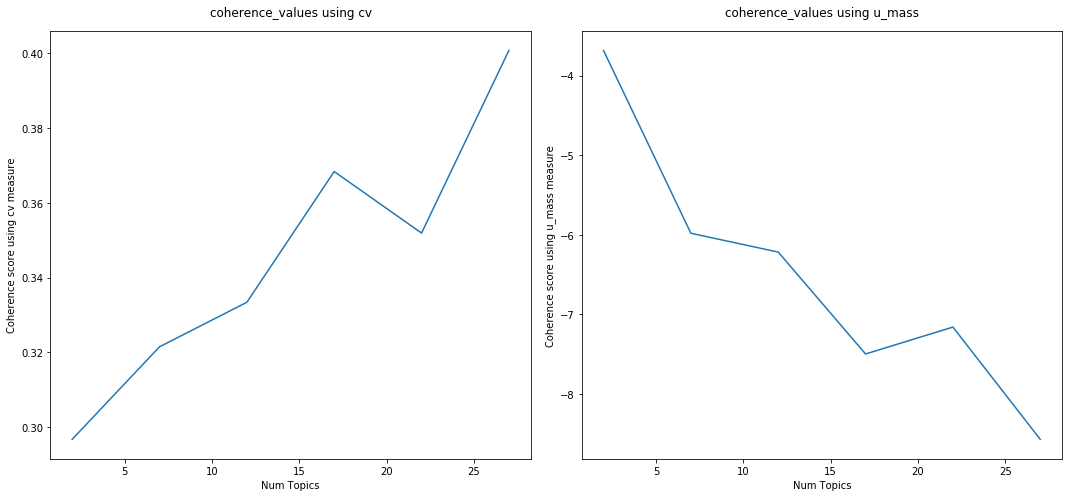

In [95]:
limit=30; start=2; step=5;

fig, (ax0,ax1) = plt.subplots(1,2)
fig.set_size_inches(15,7)

x = range(start, limit, step)
ax0.plot(x, lda_coherence_cv_values)
ax0.set_xlabel("Num Topics")
ax0.set_ylabel("Coherence score using cv measure")
ax0.set_title(("coherence_values using cv"), y=1.02)


# Show graph
import matplotlib.pyplot as plt

x = range(start, limit, step)
ax1.plot(x, lda_coherence_um_values)
ax1.set_xlabel("Num Topics")
ax1.set_ylabel("Coherence score using u_mass measure")
ax1.set_title(("coherence_values using u_mass"), y=1.02)

plt.tight_layout()


Based on coherence scores, a topic size of about 25+ should give the best score but it would create topics with lot of repeated key words. So next best fit would be the next highest score that is around topic size of 17 that should give a Coherence score of 0.37. Above we have already created topic cluster of size 10 , so let us analyze the topics here. With 17 topics, also we do expected to see repeated keywords.

### Dominant topic per document/user review

Each user review will be composed of multiple topics but typically only 1 of the topics is dominant. Let's find the dominant topic for each sentence and try for some viz

In [96]:
def format_topics_sentences(ldamodel, corpus, texts):
    # Init output
    sent_topics_df = pd.DataFrame()

    # Get main topic in each document
    for i, row_list in enumerate(ldamodel[corpus]):
        row = row_list[0] if ldamodel.per_word_topics else row_list            
        # print(row)
        row = sorted(row, key=lambda x: (x[1]), reverse=True)
        # Get the Dominant topic, Perc Contribution and Keywords for each document
        for j, (topic_num, prop_topic) in enumerate(row):
            if j == 0:  # => dominant topic
                wp = ldamodel.show_topic(topic_num)
                topic_keywords = ", ".join([word for word, prop in wp])
                sent_topics_df = sent_topics_df.append(pd.Series([int(topic_num), round(prop_topic,4), topic_keywords]), ignore_index=True)
            else:
                break
    sent_topics_df.columns = ['Dominant_Topic', 'Perc_Contribution', 'Topic_Keywords']

    # Add original text to the end of the output
    contents = pd.Series(texts)
    sent_topics_df = pd.concat([sent_topics_df, contents], axis=1)
    return(sent_topics_df)


df_topic_sents_keywords = format_topics_sentences(ldamodel=base_lda_model, corpus=corpus, texts=user_reviews)

# Format
df_dominant_topic = df_topic_sents_keywords.reset_index()
df_dominant_topic.columns = ['Document_No', 'Dominant_Topic', 'Topic_Perc_Contrib', 'Keywords', 'Text']
df_dominant_topic

,Document_No,Dominant_Topic,Topic_Perc_Contrib,Keywords,Text
0,0,6.0,0.7700,"scene, life, people, think, way, tell, love, r...","[people, rate, star, forget, review, people, c..."
1,1,6.0,0.7688,"scene, life, people, think, way, tell, love, r...","[user, freqeteq, review, point, especially, fa..."
2,2,6.0,0.5740,"scene, life, people, think, way, tell, love, r...","[bell, come, long, way, excellent, base, true,..."
3,3,6.0,0.4045,"scene, life, people, think, way, tell, love, r...","[bad, hollywood, change, fit, perceive, agenda..."
4,4,6.0,0.4003,"scene, life, people, think, way, tell, love, r...","[think, true, live, consequence, action, hope,..."
...,...,...,...,...,...
4449,4449,6.0,0.4437,"scene, life, people, think, way, tell, love, r...","[familiar, case, think, tv, star, late, elizab..."
4450,4450,6.0,0.3893,"scene, life, people, think, way, tell, love, r...","[like, long, slow, draw, boring, period, piece..."
4451,4451,4.0,0.3017,"man, woman, borden, art, lizzie, ip, murder, y...","[lizzie, agenda, historical, incident, brutal,..."
4452,4452,6.0,0.4121,"scene, life, people, think, way, tell, love, r...","[acting, photography, develop, ambiguous, poin..."


In [97]:
df_dominant_topic["Dominant_Topic"].unique()

array([6., 2., 9., 5., 0., 4., 8., 3., 1., 7.])

In [104]:
print(len(df_dominant_topic["Keywords"][10]))
print(df_dominant_topic["Keywords"].unique())
print()
print(df_dominant_topic["Keywords"][4451])

61
['scene, life, people, think, way, tell, love, real, look, play'
 'man, year, world, work, war, life, script, dream, performance, action'
 'miyazaki, jiro, danny, self, irish, fail, ground, decent, pacino, hang'
 'historical, war, wire, truth, use, history, political, mary, american, group'
 'paul, christopher, jackie, brian, william, piece, accent, old, version, knight'
 'man, woman, borden, art, lizzie, ip, murder, yen, tennis, black'
 'life, wilson, wind, son, family, relationship, child, rise, boy, period'
 'king, shakespeare, queen, philippe, victoria, jump, abdul, drug, society, terrible'
 'kill, webb, escobar, pablo, tyson, selma, marilyn, dench, civil, branagh'
 'actress, prison, linda, sevigny, renner, jeremy, greene, lovelace, ray, michael']

man, woman, borden, art, lizzie, ip, murder, yen, tennis, black


In [99]:
df_dominant_topic[["Dominant_Topic","Document_No"]].groupby(by=['Dominant_Topic']).count()

,Document_No
Dominant_Topic,
0.0,7
1.0,5
2.0,149
3.0,6
4.0,25
5.0,58
6.0,4137
7.0,2
8.0,54


Above stats show that there is 1 prominent cluster for 1 topic consisting of most of the user reviews and very small clusters for other topics. Let's try to plot this.

In [100]:
# Get topic weights and dominant topics ------------
from sklearn.manifold import TSNE
from bokeh.plotting import figure, output_file, show
from bokeh.models import Label
from bokeh.io import output_notebook

# Get topic weights
topic_weights = []
for i, row_list in enumerate(base_lda_model[corpus]):
    topic_weights.append([w for i, w in row_list[0]])

# Array of topic weights    
arr = pd.DataFrame(topic_weights).fillna(0).values

# Keep the well separated points (optional)
arr = arr[np.amax(arr, axis=1) > 0.35]

# Dominant topic number in each doc
topic_num = np.argmax(arr, axis=1)

# tSNE Dimension Reduction
tsne_model = TSNE(n_components=2, verbose=1, random_state=0, angle=.99, init='pca')
tsne_lda = tsne_model.fit_transform(arr)

# Plot the Topic Clusters using Bokeh
output_notebook()
n_topics = 10
mycolors = np.array([color for name, color in mcolors.TABLEAU_COLORS.items()])
plot = figure(title="t-SNE Clustering of {} LDA Topics".format(n_topics), 
              plot_width=900, plot_height=700)
plot.scatter(x=tsne_lda[:,0], y=tsne_lda[:,1], color=mycolors[topic_num])
show(plot)

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 3384 samples in 0.001s...
[t-SNE] Computed neighbors for 3384 samples in 0.133s...
[t-SNE] Computed conditional probabilities for sample 1000 / 3384
[t-SNE] Computed conditional probabilities for sample 2000 / 3384
[t-SNE] Computed conditional probabilities for sample 3000 / 3384
[t-SNE] Computed conditional probabilities for sample 3384 / 3384
[t-SNE] Mean sigma: 0.035876
[t-SNE] KL divergence after 250 iterations with early exaggeration: 72.835297
[t-SNE] KL divergence after 1000 iterations: 1.385160


Loading BokehJS ...

In [110]:
unique_elements, counts_elements = np.unique(topic_num, return_counts=True)
print(np.asarray((unique_elements, counts_elements)))

[[   0    1    2    3    4    5    6    7    8]
 [   2   39   11   23  310 1531 1459    8    1]]


####  How big are the user reviews as a whole and by topic. Below is the plot of user reviews' word counts distribution

This is frequency of the word count of the processed user review comment

max of topic length : 733


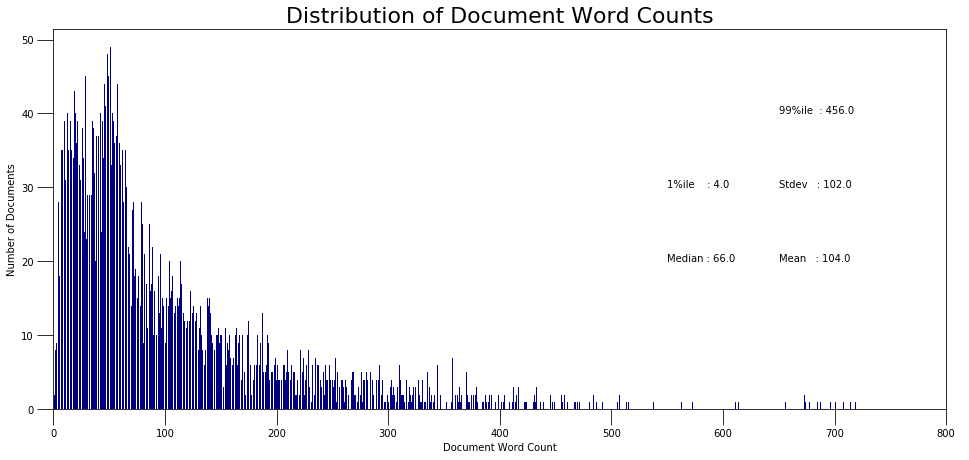

In [101]:
doc_lens = [len(d) for d in df_dominant_topic.Text]
print("max of topic length :", max(doc_lens))

# Plot
plt.figure(figsize=(16,7))
plt.hist(doc_lens, bins = 1000, color='navy')
plt.text(650, 20, "Mean   : " + str(round(np.mean(doc_lens))))
plt.text(550, 20, "Median : " + str(round(np.median(doc_lens))))
plt.text(650, 30, "Stdev   : " + str(round(np.std(doc_lens))))
plt.text(550,  30, "1%ile    : " + str(round(np.quantile(doc_lens, q=0.01))))
plt.text(650,  40, "99%ile  : " + str(round(np.quantile(doc_lens, q=0.99))))

plt.gca().set(xlim=(0, 800), ylabel='Number of Documents', xlabel='Document Word Count')
plt.tick_params(size=16)
plt.xticks(np.linspace(0,800,9))
plt.title('Distribution of Document Word Counts', fontdict=dict(size=22))
plt.show()

This plot is left-skewed for the number of dominant words in documents(user reviews ). A lot of user reviews have  a word count of 10-60 and the number decreases with increase in the word counts

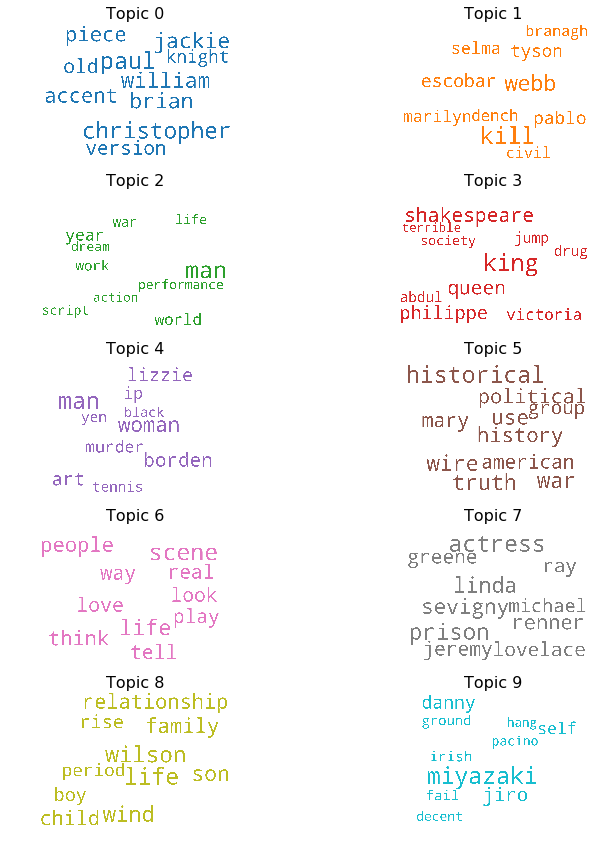

In [102]:
# 1. Wordcloud of Top N words in each topic


cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]  # more colors: 'mcolors.XKCD_COLORS'

cloud = WordCloud(stopwords=sp_nlp.Defaults.stop_words,
                  background_color='white',
                  width=2500,
                  height=1800,
                  max_words=10,
                  colormap='tab10',
                  color_func=lambda *args, **kwargs: cols[i],
                  prefer_horizontal=1.0)

topics = base_lda_model.show_topics(formatted=False)

fig, axes = plt.subplots(5, 2, figsize=(12,12), sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    fig.add_subplot(ax)
    topic_words = dict(topics[i][1])
    cloud.generate_from_frequencies(topic_words, max_font_size=300)
    plt.gca().imshow(cloud)
    plt.gca().set_title('Topic ' + str(i), fontdict=dict(size=16))
    plt.gca().axis('off')


plt.subplots_adjust(wspace=0, hspace=0)
plt.axis('off')
plt.margins(x=0, y=0)
plt.tight_layout()
plt.show()

Above we have created word clouds of 10 words for the 10 topics based on the topic weights. Let us try to find out descriptions for these topics.

Topic 0 : character  
Topic 1 : civil crimes   
Topic 2 : war   
Topic 3 : English history - Shakespeare, King , Queen  
Topic 4 : black man and woman  
Topic 5 : historical wars and politics  
Topic 6 : about the movie  
Topic 7 : actress  
Topic 8 : relationship and family  
Topic 9 : International movies  

<a id="topicmodelsklearn"></a>
<a href="#top">Back to Top</a>

### Topic Modelling with scikit Learn

Is the model from Genism different from scikit learn ?? Let's find out. Using scikit learn we can apply grid search.

We already have pre-processed documents i.e. user review comments ( pre-procesed, lemmatixed , stop words removed ) and will be using those as input for the Count Vectorizer. LDA, being a probabilistic graphical model ( i.e. dealing with probabilities ) only requires raw counts, so a CountVectorizer is used.

In [117]:
# Build LDA Model
lda_model = LatentDirichletAllocation(n_topics=20,               # Number of topics
                                      max_iter=10,               # Max learning iterations
                                      learning_method='online',   
                                      random_state=100,          # Random state
                                      batch_size=128,            # n docs in each learning iter
                                      evaluate_every = -1,       # compute perplexity every n iters, default: Don't
                                      n_jobs = -1,               # Use all available CPUs
                                     )
lda_output = lda_model.fit_transform(data_vectorized)

print(lda_model)  # Model attributes

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)


In [118]:
LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7,
             learning_method='online', learning_offset=10.0,
             max_doc_update_iter=100, max_iter=10, mean_change_tol=0.001,
             n_components=10, n_jobs=-1, n_topics=20, perp_tol=0.1,
             random_state=100, topic_word_prior=None,
             total_samples=1000000.0, verbose=0)

In [119]:
# Log Likelyhood: Higher the better
print("Log Likelihood: ", lda_model.score(data_vectorized))

# Perplexity: Lower the better. Perplexity = exp(-1. * log-likelihood per word)
print("Perplexity: ", lda_model.perplexity(data_vectorized))

# See model parameters
pprint(lda_model.get_params())

Log Likelihood:  -3198751.446092584
Perplexity:  2640.3303792225865
{'batch_size': 128,
 'doc_topic_prior': None,
 'evaluate_every': -1,
 'learning_decay': 0.7,
 'learning_method': 'online',
 'learning_offset': 10.0,
 'max_doc_update_iter': 100,
 'max_iter': 10,
 'mean_change_tol': 0.001,
 'n_components': 10,
 'n_jobs': -1,
 'n_topics': 20,
 'perp_tol': 0.1,
 'random_state': 100,
 'topic_word_prior': None,
 'total_samples': 1000000.0,
 'verbose': 0}


In [120]:
start = datetime.datetime.now()
print("Task : Initialize GridSearchCV")
print("started at :",start)

# Define Search Param
search_params = {'n_components': [5, 10, 15, 20, 25, 30], 'learning_decay': [.5, .7, .9]}

# Init the Model
lda = LatentDirichletAllocation()

# Init Grid Search Class
model = GridSearchCV(lda, param_grid=search_params)

# Do the Grid Search
model.fit(data_vectorized)

end = datetime.datetime.now()
print("Ended at :",end)
print("Total Time taken :", end-start)

Task : Initialize GridSearchCV
started at : 2019-08-12 21:33:58.043287
Ended at : 2019-08-12 21:47:23.523885
Total Time taken : 0:13:25.480598


In [121]:
start = datetime.datetime.now()
print("Task : GridSearchCV on LDA")
print("started at :",start)

GridSearchCV(cv=None, error_score='raise',
       estimator=LatentDirichletAllocation(batch_size=128, doc_topic_prior=None,
             evaluate_every=-1, learning_decay=0.7, learning_method=None,
             learning_offset=10.0, max_doc_update_iter=100, max_iter=10,
             mean_change_tol=0.001, n_components=10, n_jobs=1,
             n_topics=None, perp_tol=0.1, random_state=None,
             topic_word_prior=None, total_samples=1000000.0, verbose=0),
       fit_params=None, iid=True, n_jobs=1,
       param_grid={'n_topics': [5, 10, 15, 20, 25, 30], 'learning_decay': [0.5, 0.7, 0.9]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring=None, verbose=0)

end = datetime.datetime.now()
print("Ended at :",end)
print("Total Time taken :", end-start)

Task : GridSearchCV on LDA
started at : 2019-08-12 21:47:23.534010
Ended at : 2019-08-12 21:47:23.534258
Total Time taken : 0:00:00.000248


In [122]:
# Best Model
best_lda_model = model.best_estimator_

# Model Parameters
print("Best Model's Params: ", model.best_params_)

# Log Likelihood Score
print("Best Log Likelihood Score: ", model.best_score_)

# Perplexity
print("Model Perplexity: ", best_lda_model.perplexity(data_vectorized))

Best Model's Params:  {'learning_decay': 0.5, 'n_components': 5}
Best Log Likelihood Score:  -1138907.6736296164
Model Perplexity:  2473.035673308507


In [123]:
#pyLDAvis.enable_notebook()
panel = pyLDAvis.sklearn.prepare(best_lda_model, data_vectorized, vectorizer, mds='tsne')
panel

PreparedData(topic_coordinates=               x           y  topics  cluster       Freq
topic                                                   
1       5.821489  -45.504929       1        1  27.886741
2      -2.567239  -82.943077       2        1  21.944791
0      60.936394  -89.054626       3        1  19.297069
4      26.449179 -105.867058       4        1  17.124753
3      40.770458  -57.924282       5        1  13.746646, topic_info=     Category         Freq         Term        Total  loglift  logprob
5478  Default   953.000000        woman   953.000000  30.0000  30.0000
4405  Default   730.000000       series   730.000000  29.0000  29.0000
3049  Default   443.000000         mark   443.000000  28.0000  28.0000
2662  Default   184.000000       jackie   184.000000  27.0000  27.0000
3627  Default  1873.000000  performance  1873.000000  26.0000  26.0000
...       ...          ...          ...          ...      ...      ...
1626   Topic5   166.324330          end  1281.194857  -0.0572  -5.8158
718    Topic5   155.627516         cast   916.718609   0.2110  -5.8823
1382   Topic5   153.515460     director  1032.076404   0.0788  -5.8959
343    Topic5   146.060390     audience   733.014841   0.3712  -5.9457
3489   Topic5   141.192211        oscar   593.307656   0.5488  -5.9796

[411 rows x 6 columns], token_table=      Topic      Freq      Term
term                           
23        3  0.983128  abortion
23        5  0.022344  abortion
65        1  0.271265       act
65        2  0.190091       act
65        3  0.232219       act
...     ...       ...       ...
5527      2  0.189584     young
5527      3  0.128334     young
5527      4  0.172084     young
5527      5  0.091876     young
5534      5  0.983619   zemecki

[747 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1, 5, 4])

### Seeing Topic's keywords


**Topic 1 : musical biographies**
international 

**Topic 2 :  biographies**
art - music and dance related

**Topic 3 :  biographies**
nazis and english war history

**Topic 4 :  biographies**
International

**Topic 5 :  biographies**
comedy , sport , international

Thinking 5 topics would have helped get interpretable results but even after changing the relevance metric there is not clear description from the topics. Personally I didnot infer good results from the above 5 topics. What I mentioned above are very vague keywords. Which means, although it is LDA, the implementation using Gensim and sklearn is different